# Helmholtz Data Loading and Visualization Tutorial (FNO Version)

This notebook demonstrates how to load the Helmholtz equation data using the `Helmholtz` class from the FNOBenchmarks framework and visualize the data using matplotlib.

## Overview
- **Data**: Helmholtz equation with varying coefficients and boundary conditions
- **Input**: Coefficient field a(x,y) and boundary condition bc
- **Output**: Solution u(x,y) where ∇²u + ω²a²u = 0
- **Resolution**: 128x128 grid
- **File**: `/cluster/home/lkellijs/camlab-pino/data/Helmholtz/Helmholtz.h5`
- **Dataset size**: 19,675 samples total (19,035 training / 128 validation / 512 test)
- **Domain**: [0,1] × [0,1]
- **Frequency**: ω = 5π/2
- **Architecture**: FNO (Fourier Neural Operator)


## 1. Import Libraries


In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import sys
import os   

# Add parent directory to path to import project modules
if '..' not in sys.path:
    sys.path.append('..')
    
from Problems.FNOBenchmarks import Helmholtz


# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


No ROCm runtime is found, using ROCM_HOME='/opt/rocm'


Using device: cpu


## 2. Define Network Properties

The `Helmholtz` class requires network properties even though we're only loading data. These parameters define the FNO architecture that would be used for training.


In [2]:
# Define network architecture parameters (for FNO - just like in TrainFNO.py)
network_properties = {
    # Required FNO parameters
    "modes": 16,              # Number of Fourier modes to keep
    "width": 32,              # Hidden dimension size
    "n_layers": 4,            # Number of FNO layers
    
    # Optional parameters (with defaults from default_param function)
    "padding": 0,             # Padding for convolutions
    "include_grid": 1,        # Whether to include grid information
    "FourierF": 0,            # Number of Fourier features (0 = none)
    "retrain": 42,            # Random seed
}

print("FNO Network properties defined:")
for key, value in network_properties.items():
    print(f"  {key}: {value}")


FNO Network properties defined:
  modes: 16
  width: 32
  n_layers: 4
  padding: 0
  include_grid: 1
  FourierF: 0
  retrain: 42


## 3. Initialize the Helmholtz Class

This creates the data loaders for training, validation, and testing. The FNO Helmholtz class uses the same data organization:
- Input has 2 channels: coefficient field `a` and boundary condition `bc`
- Output is the solution field `u`
- **Note**: FNO returns data in `[height, width, channels]` format instead of `[batch, channels, height, width]`


In [3]:
# Data loading parameters
batch_size = 8           # Smaller batch size for 128x128 data
training_samples = 1024  # Number of training samples to use (max 19,035)
s = 128                  # Spatial resolution (fixed for Helmholtz)
in_dist = True          # Use in-distribution data
N_max = 19675           # Total number of samples in dataset
cluster = True          # Running on cluster
pad_factor = 0          # No padding

# Initialize the FNO Helmholtz class
print("Initializing FNO Helmholtz class...")
example = Helmholtz(
    network_properties=network_properties,
    device=device,
    batch_size=batch_size,
    training_samples=training_samples,
    s=s,
    in_dist=in_dist,
    N_max=N_max,
    cluster=cluster,
    pad_factor=pad_factor
)

print(f"✓ FNO Data loaders created successfully!")
print(f"  - Training samples: {training_samples}")
print(f"  - Validation samples: 256")
print(f"  - Test samples: 256")
print(f"  - Batch size: {batch_size}")
print(f"  - Spatial resolution: {s}x{s}")
print(f"  - Total dataset size: {N_max}")


Initializing FNO Helmholtz class...
✓ FNO Data loaders created successfully!
  - Training samples: 1024
  - Validation samples: 256
  - Test samples: 256
  - Batch size: 8
  - Spatial resolution: 128x128
  - Total dataset size: 19675


## 4. Explore the Data Loaders

Let's examine the structure of our data loaders and understand the input/output format for Helmholtz equation. **Note**: FNO returns data in `[height, width, channels]` format.


In [4]:
# Access the data loaders
train_loader = example.train_loader
val_loader = example.val_loader
test_loader = example.test_loader

print("Data loader information:")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

# Get a single batch to examine data structure
print("\nExamining FNO data structure...")
for i, (inputs, outputs) in enumerate(train_loader):
    print(f"  Input shape: {inputs.shape}")  # Should be [batch, 128, 128, 2] (FNO format: HWC)
    print(f"  Output shape: {outputs.shape}") # Should be [batch, 128, 128, 1] (FNO format: HWC)
    print(f"  Input data type: {inputs.dtype}")
    print(f"  Output data type: {outputs.dtype}")
    
    # Analyze input channels (note: channels are last dimension in FNO)
    print(f"\n  Input channel analysis (FNO format):")
    print(f"    Channel 0 (coefficient a-1): range [{inputs[:, :, :, 0].min():.3f}, {inputs[:, :, :, 0].max():.3f}]")
    print(f"    Channel 1 (boundary condition): range [{inputs[:, :, :, 1].min():.3f}, {inputs[:, :, :, 1].max():.3f}]")
    print(f"  Output (solution u): range [{outputs.min():.3f}, {outputs.max():.3f}]")
    
    # Check if boundary condition is constant across spatial dimensions
    bc_first_sample = inputs[0, :, :, 1]  # Get first sample's BC channel
    bc_value = bc_first_sample[0, 0].item()  # Value at (0,0)
    is_constant = torch.allclose(bc_first_sample, torch.full_like(bc_first_sample, bc_value))
    print(f"    BC channel is spatially constant: {is_constant} (value: {bc_value:.3f})")
    
    break  # Only examine first batch


Data loader information:
  Training batches: 128
  Validation batches: 32
  Test batches: 32

Examining FNO data structure...
  Input shape: torch.Size([8, 128, 128, 2])
  Output shape: torch.Size([8, 128, 128, 1])
  Input data type: torch.float32
  Output data type: torch.float32

  Input channel analysis (FNO format):
    Channel 0 (coefficient a-1): range [0.000, 1.000]
    Channel 1 (boundary condition): range [0.257, 0.480]
  Output (solution u): range [-3.277, 2.467]
    BC channel is spatially constant: True (value: 0.281)


## 5. Visualize Individual Samples

Let's plot some individual samples to understand the Helmholtz data better. For Helmholtz equation:
- Input Channel 0: Coefficient field a(x,y) - 1
- Input Channel 1: Boundary condition (constant field)
- Output: Solution u(x,y)

**Note**: We need to handle the FNO data format `[batch, height, width, channels]`


In [5]:
# Choose colormap
cmap_coeff = 'gist_ncar'  # For coefficient field
cmap_solution = 'gist_ncar'  # For solution field


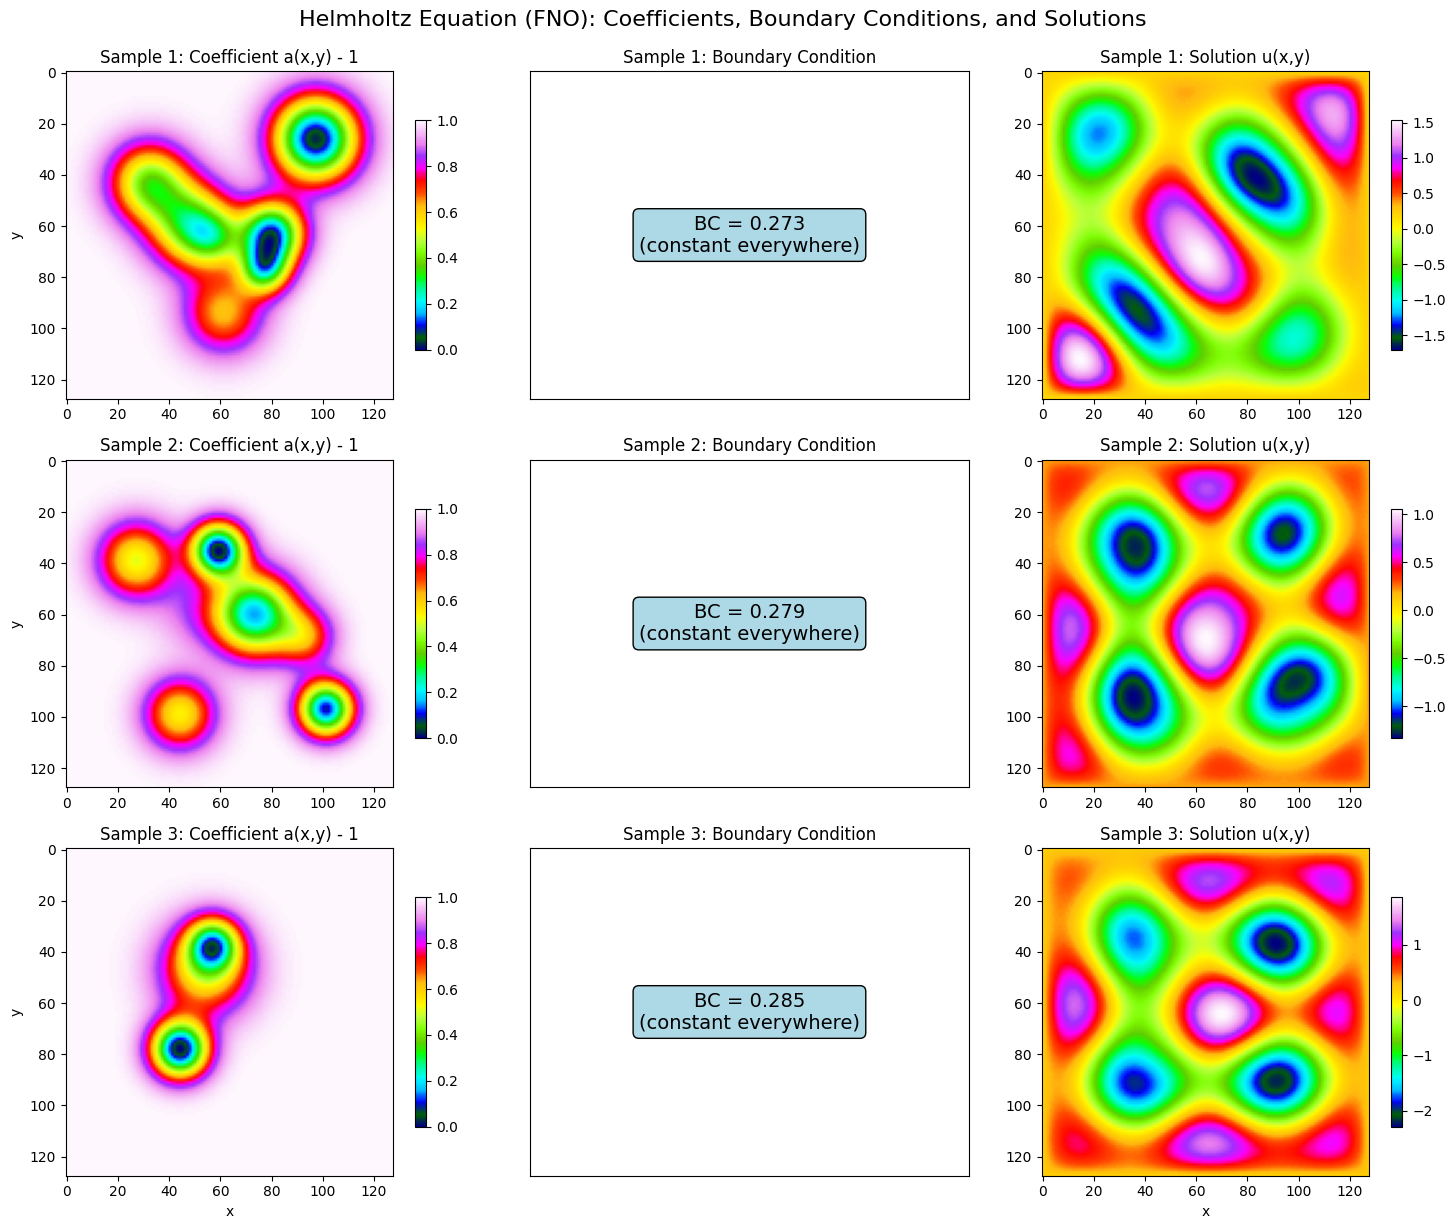

In [6]:
# Get a batch of data
inputs, outputs = next(iter(train_loader))

# Convert to numpy for plotting (FNO format: [batch, height, width, channels])
inputs_np = inputs.cpu().numpy()
outputs_np = outputs.cpu().numpy()

# Plot first 3 samples from the batch
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

n_samples = min(3, inputs_np.shape[0])

for i in range(n_samples):
    # Get boundary condition value (FNO format: [height, width, channels])
    bc_value = inputs_np[i, 0, 0, 1]
    
    # Plot coefficient field (a-1) - channel 0
    im1 = axes[i, 0].imshow(inputs_np[i, :, :, 0], cmap=cmap_coeff, aspect='equal')
    axes[i, 0].set_title(f'Sample {i+1}: Coefficient a(x,y) - 1')
    if i == n_samples-1:
        axes[i, 0].set_xlabel('x')
    axes[i, 0].set_ylabel('y')
    plt.colorbar(im1, ax=axes[i, 0], shrink=0.7)
    
    # Plot boundary condition (just show the constant value as text)
    axes[i, 1].text(0.5, 0.5, f'BC = {bc_value:.3f}\n(constant everywhere)', 
                   ha='center', va='center', fontsize=14, 
                   bbox=dict(boxstyle='round', facecolor='lightblue'))
    axes[i, 1].set_xlim(0, 1)
    axes[i, 1].set_ylim(0, 1)
    axes[i, 1].set_title(f'Sample {i+1}: Boundary Condition')
    axes[i, 1].set_xticks([])
    axes[i, 1].set_yticks([])
    
    # Plot solution - channel 0 of output
    im3 = axes[i, 2].imshow(outputs_np[i, :, :, 0], cmap=cmap_solution, aspect='equal')
    axes[i, 2].set_title(f'Sample {i+1}: Solution u(x,y)')
    if i == n_samples-1:
        axes[i, 2].set_xlabel('x')
    plt.colorbar(im3, ax=axes[i, 2], shrink=0.7)

plt.tight_layout()
plt.suptitle('Helmholtz Equation (FNO): Coefficients, Boundary Conditions, and Solutions', 
             fontsize=16, y=1.02)
plt.show()


## 6. Compare Different Data Splits

Let's compare samples from training, validation, and test sets to understand the data distribution.


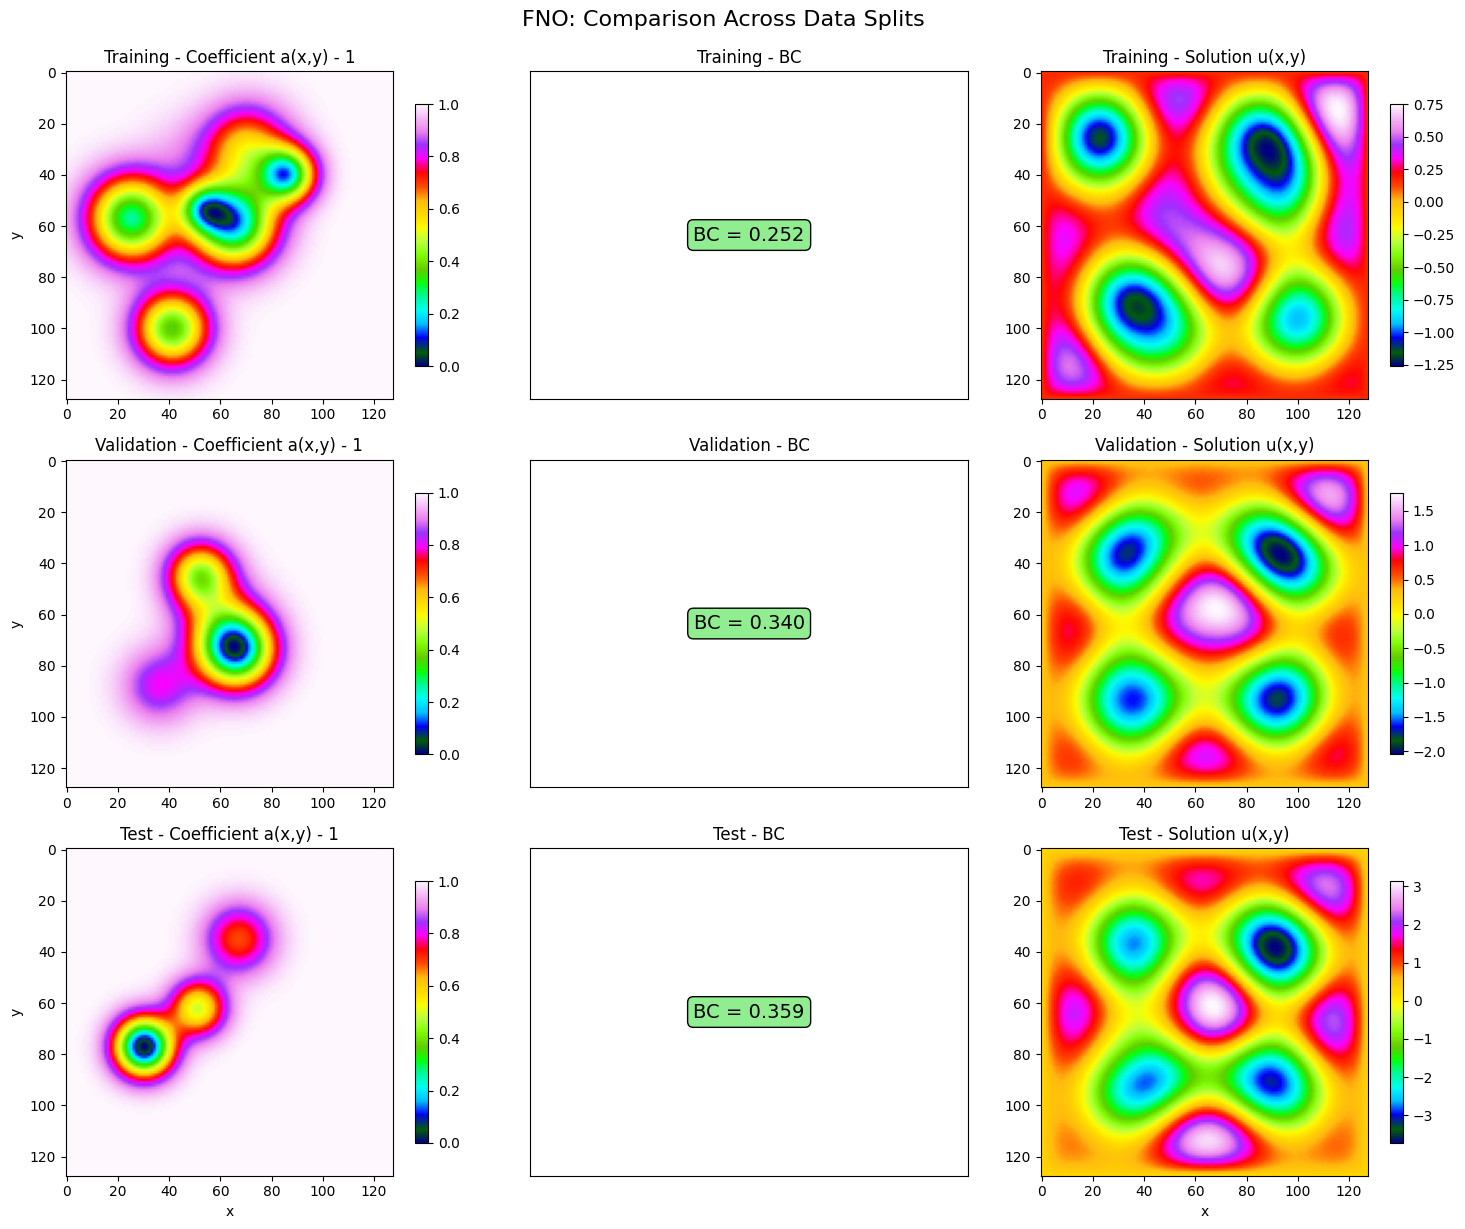

In [18]:
# Get one sample from each data split
train_inputs, train_outputs = next(iter(train_loader))
val_inputs, val_outputs = next(iter(val_loader))
test_inputs, test_outputs = next(iter(test_loader))

# Plot comparison
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

datasets = [
    (train_inputs[0], train_outputs[0], "Training"),
    (val_inputs[0], val_outputs[0], "Validation"),
    (test_inputs[0], test_outputs[0], "Test")
]

for i, (inp, out, name) in enumerate(datasets):
    # Get boundary condition value (FNO format: [height, width, channels])
    bc_value = inp[0, 0, 1].item()
    
    # Plot coefficient field - channel 0
    im1 = axes[i, 0].imshow(inp[:, :, 0].cpu().numpy(), cmap=cmap_coeff, aspect='equal')
    axes[i, 0].set_title(f'{name} - Coefficient a(x,y) - 1')
    axes[i, 0].set_ylabel('y')
    if i == 2:  # Last row
        axes[i, 0].set_xlabel('x')
    plt.colorbar(im1, ax=axes[i, 0], shrink=0.8)
    
    # Show boundary condition
    axes[i, 1].text(0.5, 0.5, f'BC = {bc_value:.3f}', 
                   ha='center', va='center', fontsize=14, 
                   bbox=dict(boxstyle='round', facecolor='lightgreen'))
    axes[i, 1].set_xlim(0, 1)
    axes[i, 1].set_ylim(0, 1)
    axes[i, 1].set_title(f'{name} - BC')
    axes[i, 1].set_xticks([])
    axes[i, 1].set_yticks([])
    
    # Plot solution - channel 0
    im3 = axes[i, 2].imshow(out[:, :, 0].cpu().numpy(), cmap=cmap_solution, aspect='equal')
    axes[i, 2].set_title(f'{name} - Solution u(x,y)')
    if i == 2:  # Last row
        axes[i, 2].set_xlabel('x')
    plt.colorbar(im3, ax=axes[i, 2], shrink=0.8)

plt.tight_layout()
plt.suptitle('FNO: Comparison Across Data Splits', fontsize=16, y=1.02)
plt.show()


torch.Size([8, 128, 128, 2])
torch.Size([8, 128, 128, 1])
torch.Size([8, 2, 128, 128])
torch.Size([8, 1, 128, 128])


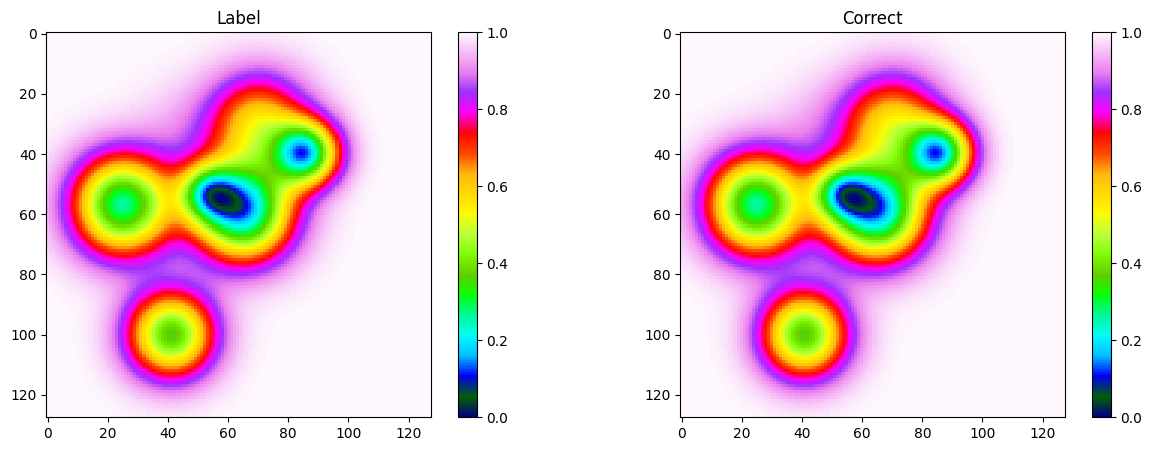

torch.Size([1, 2, 128, 128])
torch.Size([1, 1, 128, 128])


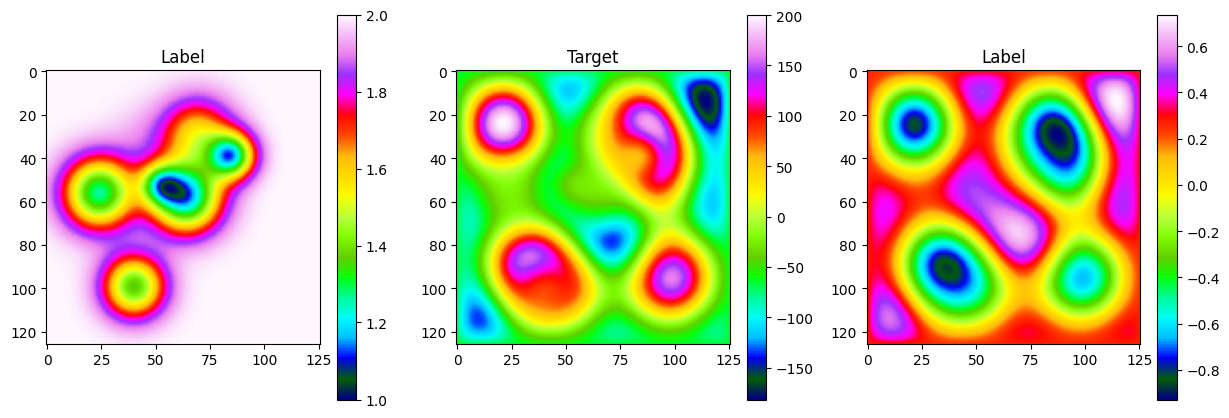

In [22]:
from Physics_NO.loss_functions.ModulePDELoss import Loss_PDE,Loss_OP, Laplace, Unnormalize
from FiniteDifferences import Laplace as FDLaplace

def to_numpy(x):
    return x.detach().cpu().numpy()

in_size = 128
batch_size = 8
print(train_inputs.shape)
print(train_outputs.shape)
input_batch = train_inputs.permute(0,3,1,2)
output_batch = train_outputs.permute(0,3,1,2)

print(input_batch.shape)
print(output_batch.shape)

input_sample = input_batch[0:1]
label_sample = output_batch[0:1]

a_plot = to_numpy(input_sample[0, 0, :, :])
a_correct = to_numpy(train_inputs[0, :, :, 0])
# make a_plot plot a_cropped
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(a_plot, cmap='gist_ncar')
plt.colorbar()
plt.title('Label')
plt.subplot(1, 2, 2)
plt.imshow(a_correct, cmap='gist_ncar')
plt.colorbar()
plt.title('Correct')
plt.show()


print(input_sample.shape)
print(label_sample.shape)

# reshape

Normalization_values=train_loader.dataset.get_max_and_min()

# Unnormalize the data
unnormalize_fn = Unnormalize("helmholtz", Normalization_values)
input_unnorm, label_unnorm = unnormalize_fn(input=input_sample, output=label_sample)

# Convert to (B, H, W) format for laplacian computation
label_unnorm_2d = label_unnorm.squeeze(1)  # (1, H, W)

# Compute laplacians using finite differences
laplace_fn = FDLaplace(s=in_size, D=1.0)
lap_label, cut_size = laplace_fn(label_unnorm_2d)

# For Helmholtz: target = -ω²a²u
omega = 5 * torch.pi / 2  # Default omega value from loss function
a = input_unnorm[0, 0, :, :]  # Coefficient field

# Crop a to match laplacian size
a_cropped = a[cut_size:-cut_size, cut_size:-cut_size]

# Compute targets
target_label = -omega**2 * a_cropped**2 * label_unnorm_2d[0, cut_size:-cut_size, cut_size:-cut_size]


label_plot = to_numpy(label_unnorm[0, 0, cut_size:-cut_size, cut_size:-cut_size])
target_label_plot = to_numpy(target_label)

# plot the label a_cropped, target_label
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(a_cropped, cmap='gist_ncar')
plt.colorbar()
plt.title('Label')
plt.subplot(1, 3, 2)
plt.imshow(target_label_plot, cmap='gist_ncar')
plt.colorbar()
plt.title('Target')
plt.subplot(1, 3, 3)
plt.imshow(label_plot, cmap='gist_ncar')
plt.colorbar()
plt.title('Label')
plt.show()



